In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import json
import shutil
from pathlib import Path
import random
import cv2
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
!pip install ultralytics

In [4]:
class DefectDatasetConverter:
    def __init__(self, img_dir, ann_dir, output_dir, class_names=None):
        """
        Initialize the dataset converter

        Args:
            img_dir: Directory containing images
            ann_dir: Directory containing JSON annotations
            output_dir: Output directory for YOLO format dataset
            class_names: List of class names (if None, will be extracted from annotations)
        """
        self.img_dir = Path(img_dir)
        self.ann_dir = Path(ann_dir)
        self.output_dir = Path(output_dir)
        self.class_names = class_names
        self.class_mapping = {}

    def setup_directories(self):
        """Create the necessary directories for YOLO format"""
        # Create main directories
        os.makedirs(self.output_dir, exist_ok=True)

        # Create directories for train/val/test splits
        for split in ['train', 'val']:
            os.makedirs(self.output_dir / 'images' / split, exist_ok=True)
            os.makedirs(self.output_dir / 'labels' / split, exist_ok=True)

    def extract_class_names(self):
        """Extract class names from annotation files if not provided"""
        if self.class_names is not None:
            return

        class_set = set()
        # Add the background/no_defect class
        class_set.add("no_defect")

        # Process all annotation files
        for ann_file in list(self.ann_dir.glob('*.json')):
            with open(ann_file, 'r') as f:
                data = json.load(f)

            for obj in data.get('objects', []):
                class_set.add(obj.get('classTitle', ''))

        # Remove empty class name if present
        if '' in class_set:
            class_set.remove('')

        # Sort class names for consistency
        self.class_names = sorted(list(class_set))

        # Create class mapping
        for idx, class_name in enumerate(self.class_names):
            self.class_mapping[class_name] = idx

        print(f"Found {len(self.class_names)} classes: {self.class_names}")

    def convert_to_yolo_format(self, json_data, image_width, image_height):
        """
        Convert JSON annotations to YOLO format

        YOLO format: [class_id, x_center, y_center, width, height]
        All values normalized between 0 and 1
        """
        yolo_annotations = []

        for obj in json_data.get('objects', []):
            class_name = obj.get('classTitle', '')
            if not class_name or class_name not in self.class_mapping:
                continue

            class_id = self.class_mapping[class_name]

            # Get coordinates
            points = obj.get('points', {})
            exterior = points.get('exterior', [])

            if len(exterior) != 2:
                continue

            x1, y1 = exterior[0]
            x2, y2 = exterior[1]

            # Calculate YOLO format (normalized)
            x_center = (x1 + x2) / 2 / image_width
            y_center = (y1 + y2) / 2 / image_height
            width = abs(x2 - x1) / image_width
            height = abs(y2 - y1) / image_height

            # Add annotation
            yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")

        return yolo_annotations

    def process_dataset(self, train_split=0.8, seed=42):
        """Process the dataset and convert to YOLO format"""
        self.setup_directories()
        self.extract_class_names()

        # Get list of all image files
        image_files = [f for f in self.img_dir.glob('*.*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
        print(f"Found {len(image_files)} images")

        # Split into train and validation sets
        train_files, val_files = train_test_split(image_files, train_size=train_split, random_state=seed)

        print(f"Train set: {len(train_files)} images")
        print(f"Validation set: {len(val_files)} images")

        # Process training set
        self._process_file_set(train_files, 'train')

        # Process validation set
        self._process_file_set(val_files, 'val')

        # Create YAML configuration file - FIXED YAML FORMATTING
        with open(self.output_dir / 'dataset.yaml', 'w') as f:
            # Write path information
            f.write(f"path: {str(self.output_dir.absolute())}\n")
            f.write("train: images/train\n")
            f.write("val: images/val\n\n")

            # Write class names in proper YAML format
            f.write("names:\n")
            for idx, name in enumerate(self.class_names):
                f.write(f"  {idx}: {name}\n")

            # Write number of classes
            f.write(f"\nnc: {len(self.class_names)}\n")

        print(f"Dataset prepared at {str(self.output_dir)}")
        print(f"YAML configuration saved to {str(self.output_dir / 'dataset.yaml')}")

    def _process_file_set(self, file_list, split):
        """Process a set of files for a specific split (train/val/test)"""
        for img_file in tqdm(file_list, desc=f"Processing {split} set"):
            # Get corresponding annotation file
            base_name = img_file.stem

            # Try different possible annotation file names
            ann_file = self.ann_dir / f"{base_name}.json"
            if not ann_file.exists():
                # Try with .jpg/.jpeg/.png extension added to the name
                for ext in ['.jpg', '.jpeg', '.png']:
                    alt_ann_file = self.ann_dir / f"{base_name}{ext}.json"
                    if alt_ann_file.exists():
                        ann_file = alt_ann_file
                        break

            # If we didn't find an annotation file, create empty annotations
            if not ann_file.exists():
                # Create empty annotation for images without defects
                yolo_anns = []
                print(f"Warning: No annotation found for {img_file.name}")
            else:
                # Load and convert annotation
                with open(ann_file, 'r') as f:
                    ann_data = json.load(f)

                # Get image dimensions
                img_width = ann_data.get('size', {}).get('width', 0)
                img_height = ann_data.get('size', {}).get('height', 0)

                if img_width == 0 or img_height == 0:
                    # Try to get dimensions from image
                    try:
                        img = cv2.imread(str(img_file))
                        img_height, img_width = img.shape[:2]
                    except Exception as e:
                        print(f"Error reading image {img_file}: {e}")
                        continue

                # Convert annotations
                yolo_anns = self.convert_to_yolo_format(ann_data, img_width, img_height)

            # Copy image
            dest_img_path = self.output_dir / 'images' / split / img_file.name
            shutil.copy(img_file, dest_img_path)

            # Write YOLO annotation
            label_path = self.output_dir / 'labels' / split / f"{img_file.stem}.txt"
            with open(label_path, 'w') as f:
                f.write("\n".join(yolo_anns))

In [5]:
def train_yolo_model(data_yaml, model_size='m', epochs=100, imgsz=640, batch=16):
    """
    Train a YOLOv8 model

    Args:
        data_yaml: Path to the dataset YAML file
        model_size: Size of YOLOv8 model ('n', 's', 'm', 'l', 'x')
        epochs: Number of training epochs
        imgsz: Image size for training
        batch: Batch size
    """
    from ultralytics import YOLO

    # Load a pre-trained model
    model = YOLO(f'yolov8{model_size}.pt')

    # Train the model
    results = model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=20,          # Early stopping patience
        save=True,            # Save checkpoints
        device='0',           # GPU device (use '0' for first GPU, 'cpu' for CPU)
        project='metal_defect_detection',
        name=f'yolov8{model_size}_defect_detector',
        pretrained=True,      # Use pre-trained weights
        optimizer='Adam',     # Optimizer
        lr0=0.001,            # Initial learning rate
        lrf=0.01,             # Final learning rate as a fraction of lr0
        momentum=0.937,       # SGD momentum/Adam beta1
        weight_decay=0.0005,  # Optimizer weight decay
        warmup_epochs=3.0,    # Warmup epochs
        warmup_momentum=0.8,  # Warmup initial momentum
        warmup_bias_lr=0.1,   # Warmup initial bias lr
        box=7.5,              # Box loss gain
        cls=1.0,              # Cls loss gain
        dfl=1.5,              # DFL loss gain
        perspective=0.0,      # Image perspective (+/- fraction)
        flipud=0.3,           # Image flip up-down probability
        fliplr=0.5,           # Image flip left-right probability
        mosaic=1.0,           # Image mosaic probability
        mixup=0.3,            # Image mixup probability
        copy_paste=0.0        # Segment copy-paste probability
    )

    return model, results

In [6]:
def detect_and_visualize(model, image_path, conf_threshold=0.25):
    """
    Detect defects in an image and visualize the results with bounding boxes

    Args:
        model: Trained YOLOv8 model
        image_path: Path to the image to detect defects in
        conf_threshold: Confidence threshold for detections
    """
    # Run inference
    results = model.predict(image_path, conf=conf_threshold, save=True)

    # Get the image
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    height, width = img.shape[:2]

    # Check if there are any detections
    if len(results[0].boxes) == 0:
        # No detections - add text
        font_size = 1.2
        text = "NO DEFECTS DETECTED"
        (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_size, 2)

        # Position text in center
        x = (width - text_width) // 2
        y = (height + text_height) // 2

        # Draw text with background
        cv2.rectangle(img, (x-10, y-text_height-10), (x+text_width+10, y+10), (0, 200, 0), -1)
        cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 255, 255), 2)
    else:
        # Draw bounding boxes on the image
        for box, cls, conf in zip(results[0].boxes.xyxy, results[0].boxes.cls, results[0].boxes.conf):
            # Get coordinates (convert to integers for drawing)
            x1, y1, x2, y2 = map(int, box.tolist())

            # Get class name and color (different color for each class)
            class_id = int(cls)
            class_name = model.names[class_id]
            color = plt.cm.rainbow(class_id / len(model.names))  # Use color map
            color = tuple(int(c * 255) for c in color[:3])  # Convert to BGR tuple

            # Draw rectangle
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

            # Draw label background
            text = f"{class_name}: {conf:.2f}"
            (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(img, (x1, y1 - text_height - 10), (x1 + text_width, y1), color, -1)

            # Draw text
            cv2.putText(img, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Display the results
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Detections: {len(results[0].boxes)}")
    plt.tight_layout()

    # Return the results
    return results[0]

In [7]:
def evaluate_model(model, data_yaml):
    """
    Evaluate model performance on the validation set

    Args:
        model: Trained YOLOv8 model
        data_yaml: Path to the dataset YAML file
    """
    # Run evaluation
    results = model.val(data=data_yaml)

    # Return metrics
    return results

In [8]:
def verify_yaml_file(yaml_path):
    """
    Verify YAML file format and print contents

    Args:
        yaml_path: Path to YAML file
    Returns:
        bool: True if YAML file is valid, False otherwise
    """
    print(f"Verifying YAML file: {yaml_path}")

    # Print raw file contents
    with open(yaml_path, 'r') as f:
        contents = f.read()
        print("Raw YAML contents:")
        print("-" * 40)
        print(contents)
        print("-" * 40)

    # Try parsing the YAML file
    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)
        print("YAML parsed successfully:")
        print(data)
        return True
    except Exception as e:
        print(f"YAML parsing error: {e}")
        return False

In [13]:
# Define paths - adjust these to match your Kaggle setup
# Typically in Kaggle, your data would be in '../input/dataset-name/'
img_dir = '/content/drive/MyDrive/img'
ann_dir = '/content/drive/MyDrive/ann'
output_dir = '/content/drive/MyDrive'

# Convert dataset to YOLO format
converter = DefectDatasetConverter(img_dir, ann_dir, output_dir)
converter.process_dataset(train_split=0.8)

# Verify YAML file before training
yaml_path = f"{output_dir}/dataset.yaml"
if not verify_yaml_file(yaml_path):
    print("YAML verification failed. Please check the format.")
    # Don't return here, just continue with a warning
    print("Warning: Proceeding with training despite YAML verification failure.")

# # Train the model
# model, train_results = train_yolo_model(
#     yaml_path,
#     model_size='l',  # Medium size model - good balance of speed and accuracy
#     epochs=10,       # Adjust based on your needs and compute constraints
#     imgsz=640,       # Standard YOLO image size
#     batch=16         # Adjust based on your GPU memory
# )

# # Evaluate the model
# eval_results = evaluate_model(model, yaml_path)
# print(f"Evaluation results: {eval_results}")

# # Demo detection on a few validation images
# val_img_dir = Path(output_dir) / 'images' / 'val'
# sample_images = list(val_img_dir.glob('*.*'))[:5]  # Get first 5 validation images

# for img_path in sample_images:
#     results = detect_and_visualize(model, img_path)

#     # Print detection information
#     print(f"\nDetections in {img_path.name}:")
#     for i, (box, cls, conf) in enumerate(zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf)):
#         class_name = model.names[int(cls)]
#         print(f"  {i+1}. {class_name}: {conf:.2f}")

Found 11 classes: ['crease', 'crescent_gap', 'inclusion', 'no_defect', 'oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot', 'waist folding', 'water_spot', 'welding_line']
Found 2341 images
Train set: 1872 images
Validation set: 469 images


Processing train set:   0%|          | 0/1872 [00:00<?, ?it/s]

Processing val set:   0%|          | 0/469 [00:00<?, ?it/s]

Dataset prepared at /content/drive/MyDrive
YAML configuration saved to /content/drive/MyDrive/dataset.yaml
Verifying YAML file: /content/drive/MyDrive/dataset.yaml
Raw YAML contents:
----------------------------------------
path: /content/drive/MyDrive
train: images/train
val: images/val

names:
  0: crease
  1: crescent_gap
  2: inclusion
  3: no_defect
  4: oil_spot
  5: punching_hole
  6: rolled_pit
  7: silk_spot
  8: waist folding
  9: water_spot
  10: welding_line

nc: 11

----------------------------------------
YAML parsing error: name 'yaml' is not defined
YAML verification failed. Please check the format.


In [14]:
def fine_tune_from_checkpoint(checkpoint_path, data_yaml, epochs=50, imgsz=640, batch=16):
    """
    Fine-tune a YOLOv8 model from a completed training checkpoint

    Args:
        checkpoint_path: Path to the checkpoint file (.pt)
        data_yaml: Path to the dataset YAML file
        epochs: Number of fine-tuning epochs
        imgsz: Image size for training
        batch: Batch size
    """
    from ultralytics import YOLO

    # Load the model from checkpoint
    model = YOLO(checkpoint_path)

    print(f"Fine-tuning from checkpoint: {checkpoint_path}")

    # Fine-tune the model - note 'resume=False' explicitly
    results = model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=20,          # Early stopping patience
        save=True,            # Save checkpoints
        device='0',           # GPU device (use '0' for first GPU, 'cpu' for CPU)
        project='metal_defect_detection',
        name=f'finetuned_defect_detector',
        pretrained=False,     # Set to False since we're loading a checkpoint
        optimizer='Adam',     # Optimizer
        lr0=0.0002,           # Lower initial learning rate for fine-tuning
        lrf=0.01,             # Final learning rate as a fraction of lr0
        momentum=0.937,       # SGD momentum/Adam beta1
        weight_decay=0.0005,  # Optimizer weight decay
        warmup_epochs=1.0,    # Reduced warmup epochs for fine-tuning
        warmup_momentum=0.8,  # Warmup initial momentum
        warmup_bias_lr=0.1,   # Warmup initial bias lr
        box=7.5,              # Box loss gain
        cls=0.5,              # Cls loss gain
        dfl=1.5,              # DFL loss gain
        resume=False          # Do not resume, start a new training with the checkpoint weights
    )

    return model, results

In [15]:
checkpoint_path = '/content/metal_defect_detection/yolov8l_defect_detector/weights/best.pt'

# Resume training from checkpoint
model, train_results = fine_tune_from_checkpoint(
    checkpoint_path,
    yaml_path,
    epochs=50,       # Additional epochs to train
    imgsz=640,
    batch=16
)

Fine-tuning from checkpoint: /content/metal_defect_detection/yolov8l_defect_detector/weights/best.pt
Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/metal_defect_detection/yolov8l_defect_detector/weights/best.pt, data=/content/drive/MyDrive/dataset.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=metal_defect_detection, name=finetuned_defect_detector2, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, ag

train: Scanning /content/drive/MyDrive/labels/train.cache... 1872 images, 6 backgrounds, 0 corrupt: 100%|██████████| 1872/1872 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 2.6±2.3 ms, read: 112.0±59.2 MB/s, size: 384.0 KB)


val: Scanning /content/drive/MyDrive/labels/val.cache... 469 images, 2 backgrounds, 0 corrupt: 100%|██████████| 469/469 [00:00<?, ?it/s]


Plotting labels to metal_defect_detection/finetuned_defect_detector2/labels.jpg... 
optimizer: Adam(lr=0.0002, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to metal_defect_detection/finetuned_defect_detector2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.23G       1.95      2.062      1.772         40        640: 100%|██████████| 117/117 [01:37<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.63it/s]

                   all        469        744      0.718      0.409      0.448      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.55G      1.858       1.87      1.699         45        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]

                   all        469        744      0.499      0.522      0.476      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       9.7G      1.839      1.781       1.67         41        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]

                   all        469        744      0.534       0.48      0.494      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       9.7G      1.797      1.741      1.661         64        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


                   all        469        744      0.557      0.464      0.459      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.68G      1.786      1.675      1.636         47        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]

                   all        469        744      0.468      0.572      0.552      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.55G      1.765      1.641      1.617         51        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.93it/s]

                   all        469        744      0.564      0.604      0.558      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.72G      1.732      1.618      1.607         60        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]

                   all        469        744      0.486      0.603      0.601      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       9.7G      1.732      1.575      1.607         57        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.75it/s]

                   all        469        744      0.535        0.6      0.583      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.66G        1.7      1.551      1.588         48        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]

                   all        469        744      0.595      0.628      0.622      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.56G      1.688      1.479      1.579         54        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.04it/s]

                   all        469        744      0.558      0.579      0.492      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.68G      1.667      1.491      1.562         55        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]

                   all        469        744      0.717      0.553      0.607      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.67G      1.654      1.443      1.541         51        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.93it/s]

                   all        469        744      0.725      0.616      0.659      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.67G      1.662      1.444      1.564         44        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]

                   all        469        744      0.581      0.622      0.645      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.59G       1.65      1.392      1.535         57        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]

                   all        469        744      0.593      0.594       0.59      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.68G      1.627      1.388      1.527         53        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.92it/s]

                   all        469        744      0.593      0.566      0.586      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.69G      1.607      1.372      1.524         65        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]

                   all        469        744      0.584      0.628      0.626      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.65G      1.616      1.319      1.522         54        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.00it/s]

                   all        469        744      0.593      0.649      0.626      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.56G      1.587      1.313       1.51         33        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]

                   all        469        744      0.626      0.642      0.657      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.71G      1.583      1.307      1.501         49        640: 100%|██████████| 117/117 [01:33<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.96it/s]

                   all        469        744      0.635       0.64      0.637      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.69G      1.575      1.261      1.491         37        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]

                   all        469        744      0.754      0.612      0.667      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.66G      1.598      1.272      1.497         59        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]

                   all        469        744      0.585      0.637      0.625      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.56G      1.551      1.252      1.476         47        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]

                   all        469        744      0.594      0.633       0.63      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.67G      1.533      1.201      1.462         54        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.92it/s]

                   all        469        744      0.699      0.654      0.672      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.68G      1.526      1.185       1.46         52        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]

                   all        469        744      0.613      0.645      0.648      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.67G      1.512      1.186      1.437         49        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]

                   all        469        744      0.671        0.6       0.63      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.55G      1.483      1.137      1.439         63        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.92it/s]

                   all        469        744       0.65      0.671       0.69      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.71G      1.479      1.131      1.424         61        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.95it/s]

                   all        469        744       0.66      0.613      0.647      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.69G      1.456       1.11      1.423         57        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]

                   all        469        744       0.75      0.603      0.669       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.68G      1.465      1.127       1.44         59        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]

                   all        469        744      0.665      0.637      0.662       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.58G       1.45      1.088      1.412         56        640: 100%|██████████| 117/117 [01:33<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.88it/s]

                   all        469        744      0.653      0.696      0.683      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.71G      1.428      1.037      1.391         60        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]

                   all        469        744      0.662       0.65      0.677      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.68G      1.409       1.04      1.379         47        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.01it/s]

                   all        469        744      0.613      0.666      0.668      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.68G      1.401      1.008      1.385         56        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]

                   all        469        744        0.7      0.649      0.667      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.59G      1.372      1.008      1.364         41        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]

                   all        469        744      0.619      0.638      0.641       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       9.7G      1.379     0.9845      1.366         39        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.89it/s]

                   all        469        744      0.652      0.646      0.664      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.69G      1.347     0.9595      1.351         65        640: 100%|██████████| 117/117 [01:33<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.75it/s]

                   all        469        744      0.618      0.687      0.673      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.68G      1.339       0.94      1.329         40        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.98it/s]

                   all        469        744      0.719      0.631      0.686      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.88G      1.342     0.9655      1.337         34        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]

                   all        469        744      0.662       0.67      0.684      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       9.7G      1.301     0.9027      1.312         44        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]

                   all        469        744      0.704      0.642      0.679      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.67G      1.289     0.8823      1.315         37        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]

                   all        469        744      0.603      0.677      0.663      0.375


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.68G      1.377     0.9138      1.359         19        640: 100%|██████████| 117/117 [01:34<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.95it/s]

                   all        469        744      0.705      0.658      0.687      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.58G      1.351     0.8447      1.343         23        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]

                   all        469        744      0.651      0.689      0.688      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.69G      1.302     0.8359       1.32         18        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]

                   all        469        744      0.696      0.659      0.689      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.65G       1.29     0.8097      1.305         25        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]

                   all        469        744      0.641      0.699      0.705      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.67G      1.279     0.7946      1.298         17        640: 100%|██████████| 117/117 [01:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]

                   all        469        744      0.666      0.672      0.693      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.58G      1.268     0.7728      1.314         30        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]

                   all        469        744      0.728      0.684      0.708      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.69G      1.254     0.7754        1.3         20        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]

                   all        469        744      0.657      0.731      0.709      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.68G      1.224      0.756       1.28         23        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.95it/s]

                   all        469        744      0.734      0.641       0.69      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.67G       1.21     0.7281      1.254         17        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]

                   all        469        744       0.76      0.642      0.696      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.88G      1.204     0.7228      1.253         21        640: 100%|██████████| 117/117 [01:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.03it/s]

                   all        469        744       0.75      0.639       0.69      0.398



50 epochs completed in 1.471 hours.
Optimizer stripped from metal_defect_detection/finetuned_defect_detector2/weights/last.pt, 87.6MB
Optimizer stripped from metal_defect_detection/finetuned_defect_detector2/weights/best.pt, 87.6MB

Validating metal_defect_detection/finetuned_defect_detector2/weights/best.pt...
Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,615,089 parameters, 0 gradients, 164.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


                   all        469        744      0.641      0.699      0.705      0.405
                crease         10         19      0.405      0.158      0.267      0.122
          crescent_gap         54         54        0.8      0.981       0.96      0.627
             inclusion         39         65      0.447      0.338      0.353      0.119
             no_defect         12         12       0.88          1      0.995      0.995
              oil_spot         44        116      0.746      0.767        0.8      0.386
         punching_hole         67         67      0.954      0.938      0.978      0.542
            rolled_pit          7         17      0.263      0.231      0.223      0.128
             silk_spot        148        175      0.535      0.611      0.539      0.232
         waist folding         33         33      0.668      0.879      0.882      0.482
            water_spot         60         70      0.715        0.8      0.808      0.453
          welding_lin

In [17]:
from google.colab import files
files.download('/content/metal_defect_detection/finetuned_defect_detector2/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,615,089 parameters, 0 gradients, 164.9 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 180.7±21.8 MB/s, size: 428.1 KB)


val: Scanning /content/drive/MyDrive/labels/val.cache... 469 images, 2 backgrounds, 0 corrupt: 100%|██████████| 469/469 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


                   all        469        744      0.639      0.699      0.704      0.403
                crease         10         19      0.377      0.159      0.264      0.121
          crescent_gap         54         54        0.8      0.981       0.96      0.622
             inclusion         39         65      0.448      0.338      0.351      0.119
             no_defect         12         12       0.88          1      0.995      0.995
              oil_spot         44        116      0.746      0.767      0.801      0.385
         punching_hole         67         67      0.954      0.938      0.979       0.54
            rolled_pit          7         17       0.26      0.228      0.223      0.128
             silk_spot        148        175      0.533      0.606      0.537       0.23
         waist folding         33         33      0.668      0.879      0.883      0.478
            water_spot         60         70       0.72      0.809      0.808      0.452
          welding_lin

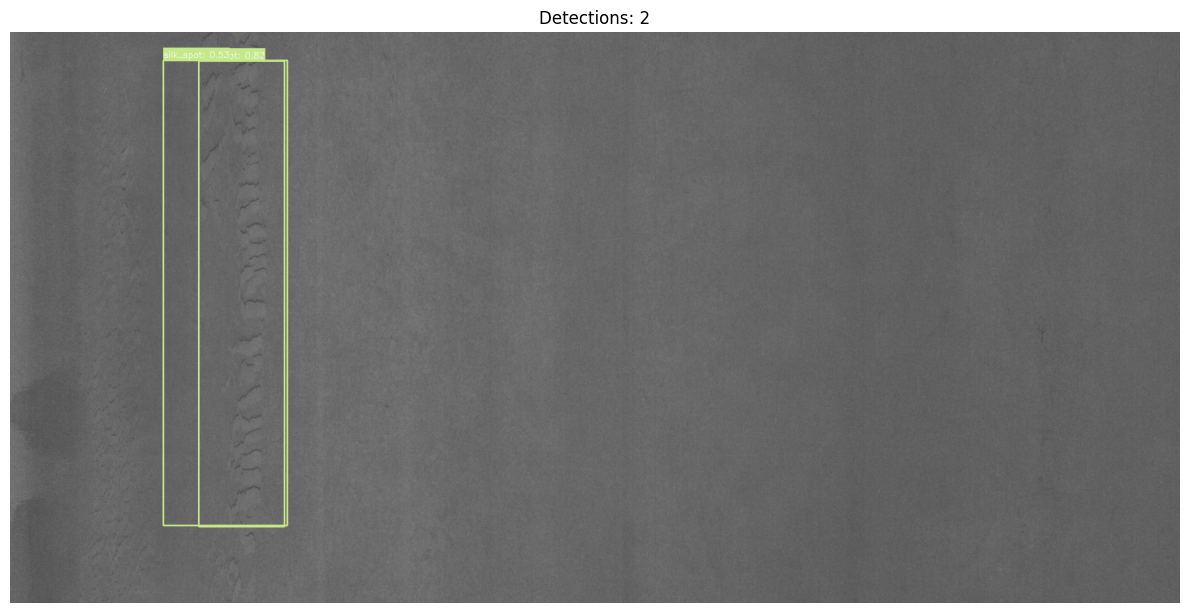

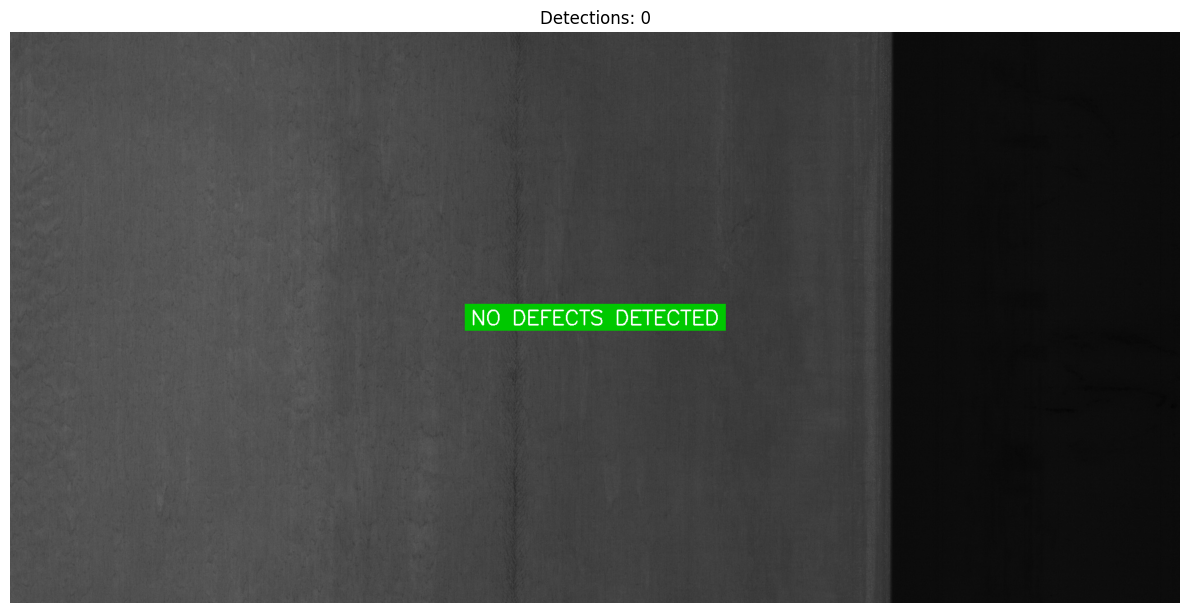

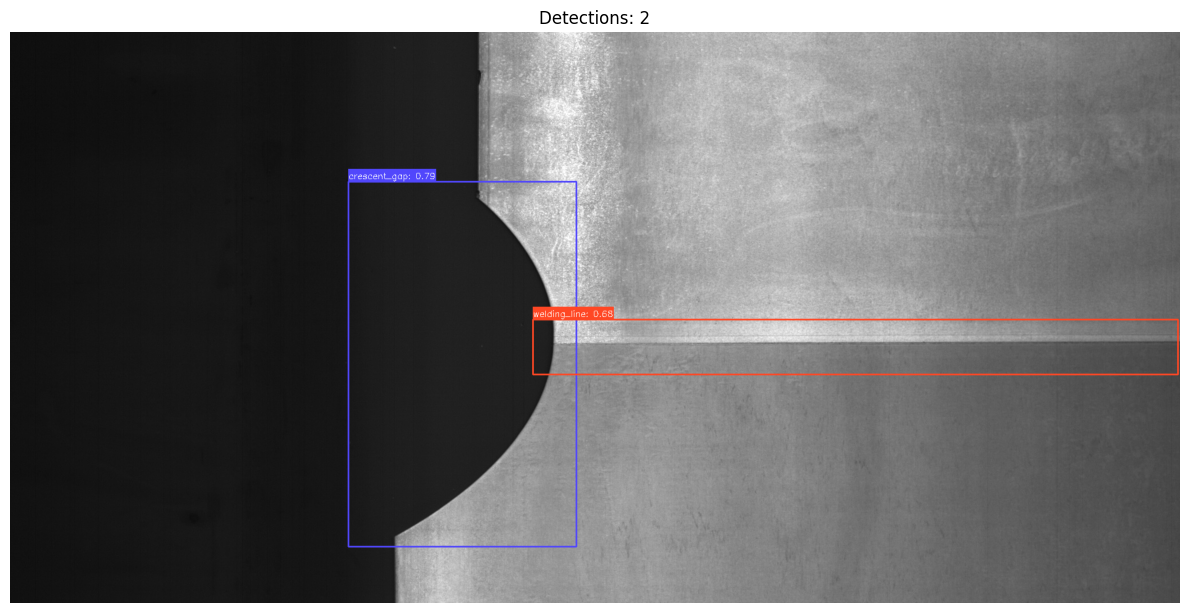

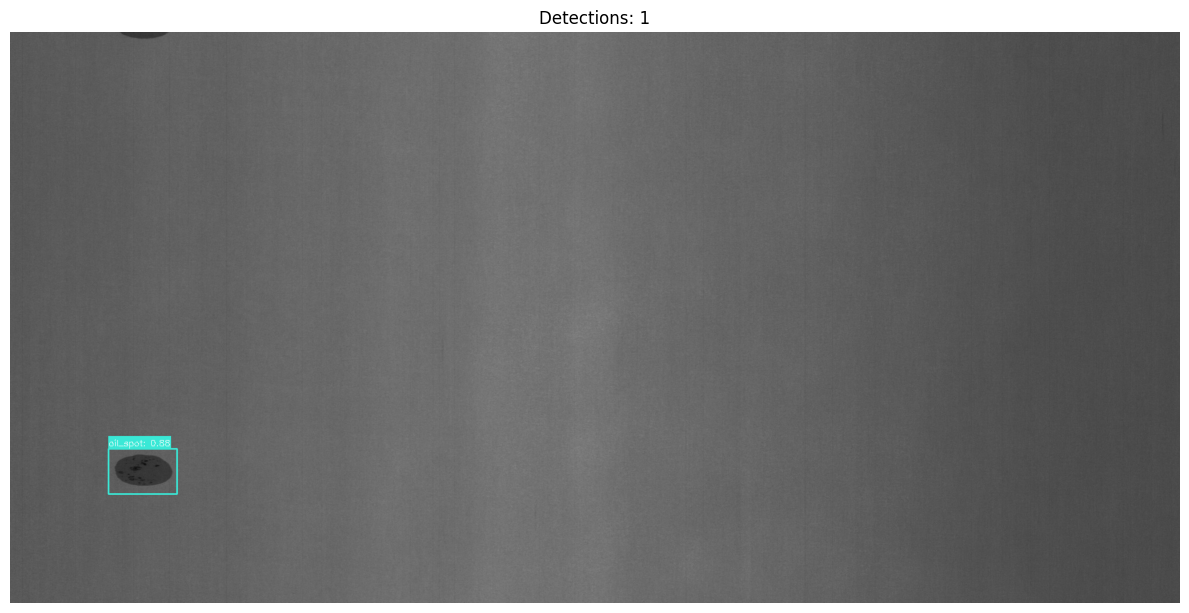

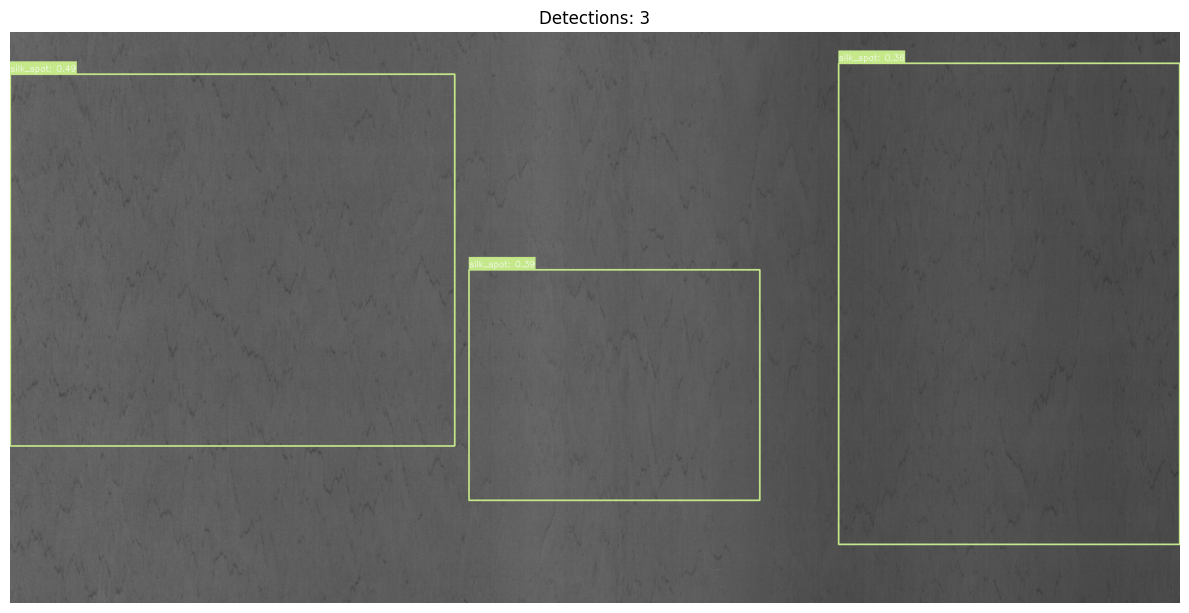

In [16]:
eval_results = evaluate_model(model, yaml_path)
print(f"Evaluation results: {eval_results}")

# Demo detection on a few validation images
val_img_dir = Path(output_dir) / 'images' / 'val'
sample_images = list(val_img_dir.glob('*.*'))[:5]  # Get first 5 validation images

for img_path in sample_images:
    results = detect_and_visualize(model, img_path)

    # Print detection information
    print(f"\nDetections in {img_path.name}:")
    for i, (box, cls, conf) in enumerate(zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf)):
        class_name = model.names[int(cls)]
        print(f"  {i+1}. {class_name}: {conf:.2f}")